Saving Google_Stock_Price_Test.csv to Google_Stock_Price_Test.csv
Saving Google_Stock_Price_Train.csv to Google_Stock_Price_Train.csv


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1027
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 16/50
38/38 ━

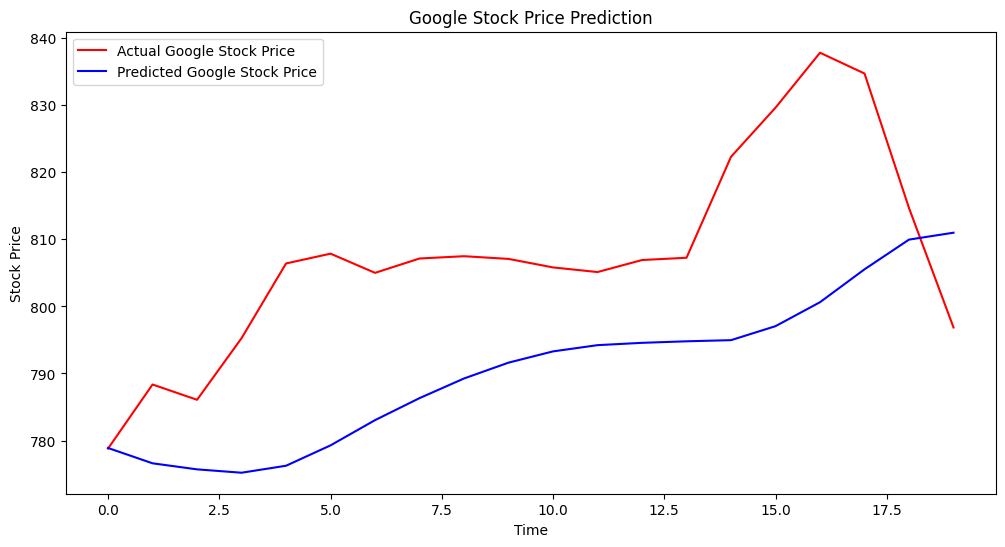

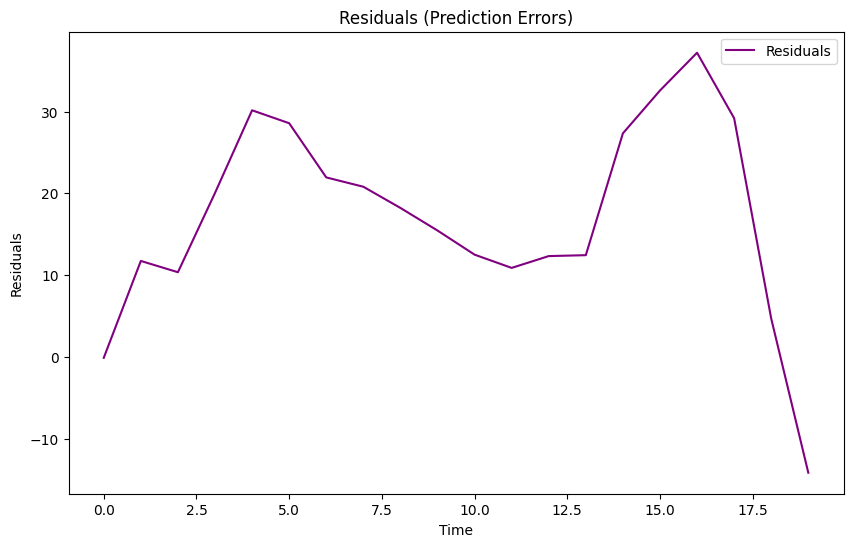

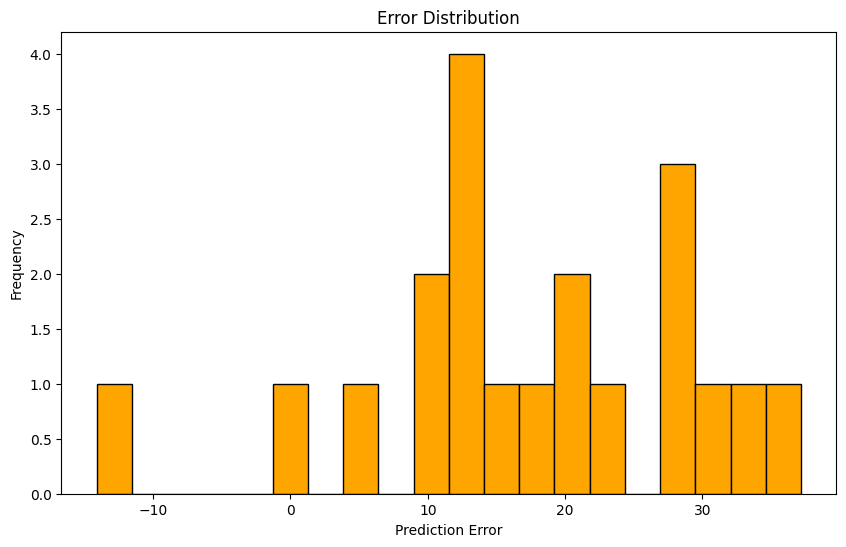

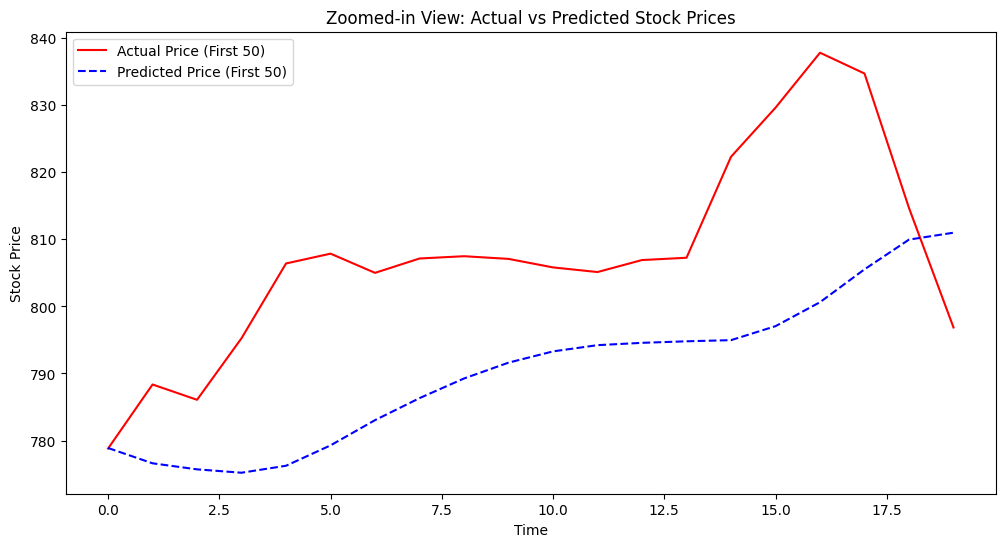

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import files
uploaded = files.upload()
# Load datasets
train_df = pd.read_csv("/content/Google_Stock_Price_Train.csv")
test_df = pd.read_csv("/content/Google_Stock_Price_Test.csv")

# Extract "Open" column as NumPy arrays
train_prices = train_df[['Open']].values
test_prices = test_df[['Open']].values

# Normalize training data using MinMaxScaler
normalizer = MinMaxScaler((0, 1))
train_scaled = normalizer.fit_transform(train_prices)

# Function to generate sequences and targets for LSTM
def prepare_sequences(data, window_size=60):
    seq_data, targets = [], []
    for idx in range(window_size, len(data)):
        seq_data.append(data[idx - window_size:idx, 0])
        targets.append(data[idx, 0])
    return np.array(seq_data), np.array(targets)

# Prepare training data sequences
seq_length = 60
X_train_seq, y_train_seq = prepare_sequences(train_scaled, seq_length)

# Reshape input data to 3D for LSTM
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))

# Build the LSTM model
stock_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
stock_model.compile(optimizer='adam', loss='mse')

# Train the model
stock_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32)

# Prepare test data
combined_data = pd.concat([train_df['Open'], test_df['Open']], axis=0)
test_input = combined_data[-(len(test_df) + seq_length):].values.reshape(-1, 1)
test_input = normalizer.transform(test_input)

X_test_seq = []
for i in range(seq_length, len(test_input)):
    X_test_seq.append(test_input[i - seq_length:i, 0])

X_test_seq = np.array(X_test_seq).reshape((-1, seq_length, 1))

# Predict the stock prices
predicted_prices = stock_model.predict(X_test_seq)
predicted_prices = normalizer.inverse_transform(predicted_prices)

# Calculate evaluation metrics
mse = mean_squared_error(test_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_prices, predicted_prices)
mape = mean_absolute_percentage_error(test_prices, predicted_prices)

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Residuals: Difference between actual and predicted
residuals = test_prices - predicted_prices

# Visualization 1: Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(test_prices, color='red', label='Actual Google Stock Price')
plt.plot(predicted_prices, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Visualization 2: Residual Plot
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.title('Residuals (Prediction Errors)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Visualization 3: Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='orange', edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# Visualization 4: Zoomed-in View of Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_prices[:50], color='red', label='Actual Price (First 50)')
plt.plot(predicted_prices[:50], color='blue', linestyle='--', label='Predicted Price (First 50)')
plt.title('Zoomed-in View: Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
